# Correlations between model performance and geospatial features

The performances resulting from the CNN can be affected by several factors. Here, the most important are evaluated as an insight into other input variables that can provide additional information to feed the model and get higher accuracies. 

The incorporation of those variables or the affectations differs from well to well. Some can modify the groundwater levels in some wells but not in others. Here the influence of different locations is evaluated altogether.

In [1]:
#Import libraries
%matplotlib inline
import geopandas as gpd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

In [2]:
patht="D:/Erasmus/Thesis/"
pathdat=patht+"/data/"

pathshp=pathdat+"/SHP/SHP2/"
pathrast=pathdat+"/Raster/"
pathpick=pathdat+"/Pickle/"
pathfig=patht+"/Figures/"

path=r"D:\Erasmus\Thesis\Code\08072022\GW_forecasting_ML\projections/"

In [3]:
gw_sel_int_test=gpd.read_file(pathdat+"/SHP/SHP2/gw_sel_int.shp")

In [4]:
#Import spatial information per well -- results of the Accuracy_plot script
gw_sel_int=gpd.read_file(pathshp+"/gw_sel_intmod3.shp")

In [5]:
#Load error files
pathg=r'D:\Erasmus\Thesis\data\resultsCNN/'
folder2 = Path(pathg+"wihtoutRH/")
df_norh = pd.concat([
    pd.read_csv(fname)
    for fname in folder2.glob("summary_CNN_*.txt")])

In [13]:
gw_sel_int = gw_sel_int.reset_index(drop=True)
gw_sel_int['bias']=df_norh.Bias.abs().values

Create a list of wells with high model performance to use for projections

In [14]:
#Select and save pdf with model performance above 0.6 NSE and 0.7 r2 -- the selection is done for the simulation with P and T only
dfsel=gw_sel_int[['MEST_ID','r2_2','NSE_2','bias']]
#dfsel60=dfsel.loc[(dfsel['r2_2']>0.7) & (dfsel['NSE_2']>0.6)]
#dfsel60c=dfsel60['MEST_ID'].astype(str)
#dfsel60c.to_csv(path+'well_list60.txt',index=False)

## Make correlations

Pearson, Spearmann and Kendall-tau correlation coefficients. Only significant coefficients (90% confidence interval) are considered. 

Small p-values correpond to strong evidence.In this case, a confidence interval of 0.1 is used. If p-values are below 0.1, then the correlation between both variables is statistically significant. The smaller the p-value, the less plausible is the null hypothesis, meaning that the alternative hypothesis ('the slope of the regression line is nonzero') is true.

In [15]:
def bootstrap(nsamp,gw):
    vindex=[]
    for k in range(nsamp): 
        index=np.random.randint(0,len(gw), len(gw))
        vindex.append(index)
    return vindex

In [16]:
#Columns to perform the correlations
lcol=[ "FOK",'ho4_30m_sd',  'ho4_30m_ds', 'ho4_30m_lp','dist_pww',
      'dist_coast', 'imperv_buf', 'recharge_b', 'prop_211',
       'prop_231', 'prop_312', 'prop_112', 'prop_311','geo_1011', 
         'geo_115','geo_114','geo_111', 'geo_1012',
      'geo_1021','lai01_buff', 'lai06_buff', 'lai0106_bu', 'slope_buff', 'drainaged', 'twi']

#Performance indicators r2, NSE (P,T,RH) and r_2,NSE_2 (P,T)
perfor=['r2_2', 'NSE_2', 'bias']

#Create dataframe to store the correlations
lzero=np.zeros(len(lcol))
d = {'variable': lcol, 'r2_2':lzero, 'NSE_2':lzero, 'bias': lzero}
dfrval = pd.DataFrame(data=d)
dfslope= pd.DataFrame(data=d)
pval=pd.DataFrame(data=d)
spearm =pd.DataFrame(data=d)
pvalspearm= pd.DataFrame(data=d)
kendalltau= pd.DataFrame(data=d)
pvalkendallt=pd.DataFrame(data=d)


for p in perfor:
    
    lslope, lrvalue, pvalue, spearv, pvalspearv, kendv,pvalkend= [],[],[],[],[],[],[]
    for col in lcol:
        
        #Restrict values bellow 9 km l
        if col== 'dist_pww':
            sortdf=gw_sel_int.sort_values(by=col).dropna(subset=[col])[:90]
        
        #Restricted distance to coastline to 25 km
        elif col== 'dist_coast':
            sortdf=gw_sel_int.sort_values(by=col).dropna(subset=[col])[:50]
  
        else:    
            sortdf=gw_sel_int.sort_values(by=col).dropna(subset=[col])
        
        vindex=bootstrap(1000, sortdf)
        sortdf.reset_index(inplace=True)

        vlrvalue, vpvalue=[],[]   
        for i in vindex:    
            slope, intercept, r_value, p_value, std_err = stats.linregress(sortdf[col][i], sortdf[p][i])
            
            
            # add only the correlations that are statistically significant
            vlrvalue.append(round(r_value,2)) if p_value <= 0.1 else vlrvalue.append(np.nan)
            vpvalue.append(round(p_value,2)) if p_value <= 0.1 else vpvalue.append(0)
            
            
        # add only the correlations that are statistically significant
        lrvalue.append(round(np.nanmean(vlrvalue),2)) 
        pvalue.append(round(np.nanmean(vpvalue),2)) 

    dfrval[p]=lrvalue
    pval[p]=pvalue
    

In [17]:
#Select the correlation type dfrval means Pearson correlation, spearm is Spearman's Rank correlation coefficient
corrsel=dfrval.copy()
#pvalsel=pval.copy()

In [18]:
#Create a dictionary to change the codes to the proper name
dictionary={
            "FOK":'Filter depth', 
            'dist_pww':'Distance to water-works', 
            'ho4_30m_sd':'HO4_SD',
            'ho4_30m_ds':'Divide to stream distance (DSD) HO 4', 
            'ho4_30m_lp': 'HO4_LP',
            'dist_coast':'Distance to coastline', 
            'imperv_buf': 'Average Imperveousness', 
            'recharge_b':'Average long-term Recharge', 
            'prop_211':' Non-irrigated arable land',
            'prop_231': 'Pastures ' , 
            'prop_312':'Coniferous forest' ,
            'prop_112':' AS:Discontinuous urban fabric', 
            'prop_311':'Forest: Broad-leaved forest ',
            'geo_1011':'Low Relief/ High SMI',
            'geo_1012':'Low Relief/ Medium SMI',
            'geo_114':'Sink areas/ Medium SMI',
            'geo_115':'Sink areas/ Low SMI' ,
            'geo_111':'Sink areas/ High SMI',
            'geo_1021':'Moderate Relief/ low SMI',
            'lai01_buff':'LAI Jan',
            'lai06_buff' : 'LAI Jun',
            'lai0106_bu':'LAI Jun-Jan', 
            'slope_buff': 'Slope',
            'drainaged': 'Drainage density' , 
            'twi': 'Topographic wetness index'
}

corrsel["variables_d"]=corrsel['variable'].map(dictionary)
dfrvalc=corrsel.drop(['variable'],axis=1)

#pvalsel["variables_d"]=pvalsel['variable'].map(dictionary)
#pvalc=pvalsel.drop(['variable'],axis=1)

## Plot  the correlation coeficients

In [19]:
dfrvalcc=dfrvalc.copy()
dfrvalcc.rename(columns={"r2_2":"r$^2$","NSE_2":"NSE","bias":"BIAS"}, inplace=True)
dfcop=dfrvalcc[:].set_index('variables_d')

In [20]:
#importlib.reload(plt); importlib.reload(sns) #to avoid seaborn style

data1=dfcop.dropna(how='all')
data2=data1.loc[~data1["r$^2$"].isna()]
data=data2.drop(index=['LAI Jun-Jan', 'Filter depth','HO4_SD', 'HO4_LP', 'Average Imperveousness',
                ' AS:Discontinuous urban fabric','Forest: Broad-leaved forest ',
                       'Low Relief/ High SMI', 'Average long-term Recharge',
                       'Divide to stream distance (DSD) HO 4' ])
#data=data.fillna(0)

In [21]:
data.BIAS.loc[abs(data.BIAS)<=0.09]=np.nan

Text(45.7222222222222, 0.5, ' ')

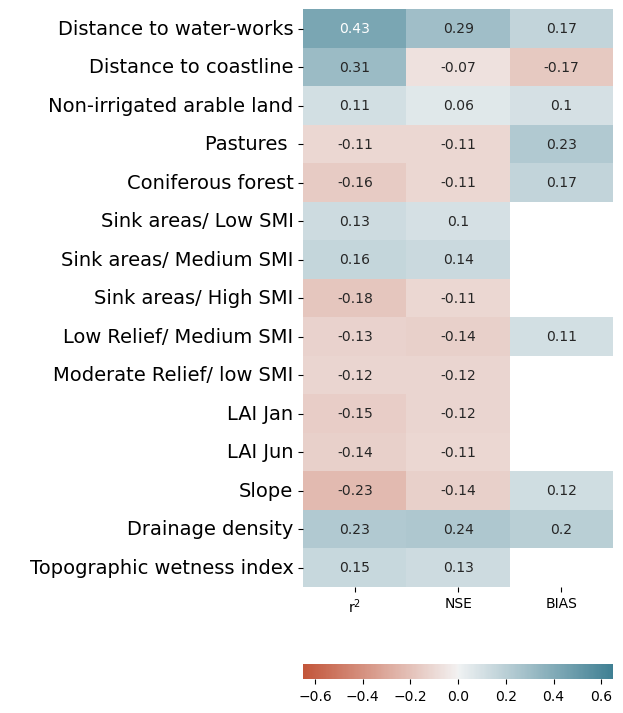

In [23]:
pathfig=r"D:\FOSTER\Figs/"
fig = plt.figure(figsize=(6,10))
cmap = sns.diverging_palette(20, 220, as_cmap=True)
ax= sns.heatmap(data, annot=True,cmap=cmap, center=0,  annot_kws={"size":10}, vmin=-.65, vmax=.65, 
                cbar=False)
ax.tick_params(axis='y', left=True, right=False, labelright=False, labelleft =True, 
               labelrotation=0, labelsize=14)
#plt.legend(loc='lower center')
cbar = ax.figure.colorbar(ax.collections[0], orientation='horizontal', pad=0.1)
cbar.outline.set_visible(False)
fig.set_size_inches(4, 10)
plt.ylabel(' ')
#plt.tight_layout()
#plt.savefig(pathfig+'matrixgeo2.pdf')

## Scatter plots

<IPython.core.display.Javascript object>


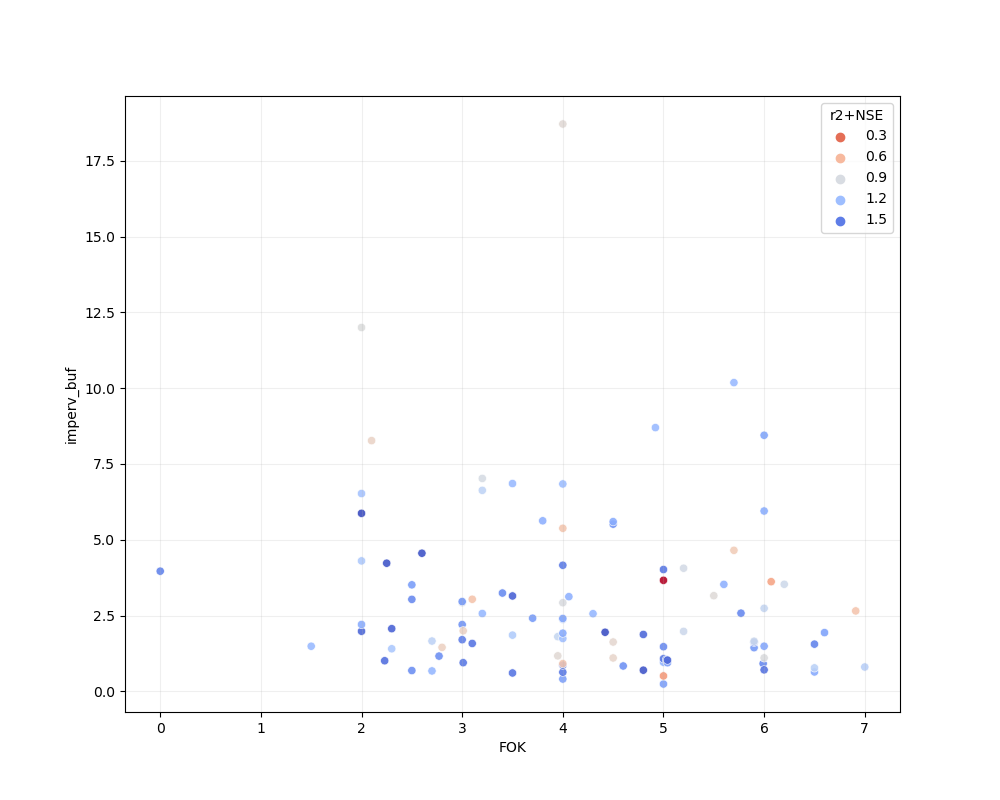

In [335]:
subset = gw_sel_int.sort_values(by=['FOK','imperv_buf'])[:100]
plt.figure(figsize=(10,8))

sns.scatterplot(x='FOK', y='imperv_buf', data=subset, 
                 hue='r2+NSE',palette="coolwarm_r", alpha=0.9)
plt.grid(True, alpha=0.2)

<IPython.core.display.Javascript object>


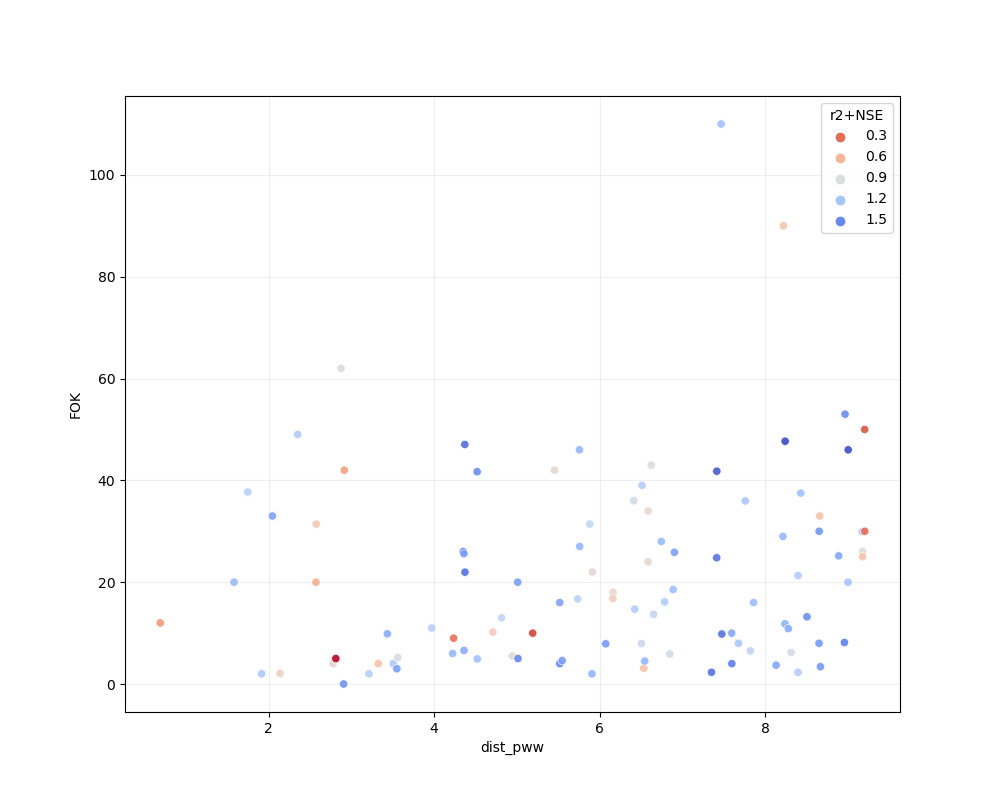

In [233]:
# Subset data

subset = gw_sel_int.sort_values(by='dist_pww')[:100]
plt.figure(figsize=(10,8))

sns.scatterplot(x='dist_pww', y='FOK', data=subset, 
                 hue='r2+NSE',palette="coolwarm_r", alpha=0.9)
plt.grid(True, alpha=0.2)

In [158]:
fig = plt.figure()
ax = plt.axes(projection='3d')

gw_sel_int2=gw_sel_int.sort_values(by='dist_pww')

# Data for a three-dimensional line
zline = gw_sel_int2['r2'][:100]
xline = gw_sel_int2['dist_pww'][:100]
yline = gw_sel_int2['FOK'][:100]
ax.scatter3D(xline, yline, zline, c=zline, cmap='viridis_r')
ax.set_xlabel('Dist waterworks')
ax.set_ylabel('Filter depth')
ax.set_zlabel('r2')


<IPython.core.display.Javascript object>

Text(0.5, 0, 'r2')